# **Studi Predictive Analytics : Microsoft Stock dengan pendekatan Time Series Forecasting dan LSTM**

Model yang dibuat menggunakan Time Series dengan LSTM. Kita akan memprediksi harga stock Microsoft dimasa yang akan datang menggunakan pendekatan Time Series Analysis. 


## **Time Series**

Time series dapat dipahami sebagai kumpulan nilai yang tersusun secara runtut dalam rentang waktu tertentu.

## **Dataset**

Dataset yang digunakan menggunakan dataset Microsoft_Stock.csv yang bisa ditemukan di kaggle.com. Dataset ini memiliki 1511 baris dan 5 kolom. Kolom yang terdapat pada dataset ini yakni Date (tanggal), Open(Harga pembukaan), High(Harga tertinggi), Low(Harga terendah), Close(Harga closing/penutup), dan Volume(volum ketersediaan stok).



In [358]:
# import library yang dibutuhkan
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



## **Membaca data menggunakan Pandas**

Disini kita akan membaca data Microsoft_Stock.csv menggunakan pandas lalu kita akan parse_dates bagian kolom date dan index_col pada bagian Date. parse_dates disini bertujuan agar tanggal dapat dikenali dalam bahasa python dan index_col bertujuan agar kolom Date menjadi sebuah index dalam data.



In [359]:
df = pd.read_csv('Microsoft_Stock.csv', parse_dates=['Date'], index_col='Date')
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455


## **Melihat tipe data**

Tipe data yang ada diinfo terdapat 1511 non-null data yang artinya tidak ada data kosong/missing value. Kolom Open, High, Low, Close bertipe float sedangkan volume bertipe integer.

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


## **Mengecek nilai menggunakan deksripsi statistika**
Deskripsi statisika digunakan untuk menggambarkan/summary data. Seperti : nilai mean, median, modus, variance, standar deviasi, quartile, range dan sejenisnya. perintah yang digunakan DataFrame.describe() Dapat dilihat bahwa pada nilai min/minimum tidak terdapat angka 0 yang mengindikasikan tidak ada missing value.



In [361]:
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


## **Mengecek nilai missing value pada setiap kolom lalu handling missing value**

Hal ini bertujuan untuk melihat apakah terdapat nilai nol atau tidak pada data. 
Dan ternyata tidak ada data yang null atau bernilai 0 dan tidak perlu melakukan handling missing value.



In [362]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## **Melihat outlier yang ada didata**
Nilai outliers (atau yang biasa disebut dengan nilai pencilan) merupakan suatu nilai yang tidak normal. Dalam kata lain, nilai tersebut bernilai jauh sekali dari pusat data. Nilai pencilan ini dapat menyebabkan distorsi terhadap nilai yang asli.

Dampaknya jika tidak serius menanggulangi nilai outliers akan berdampak pada ketidaksesuaian data analisa dan ketidakakuratan model machine learning yang dikerjakan

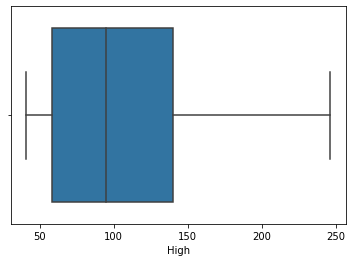

In [363]:
sns.boxplot(x=df['High'])

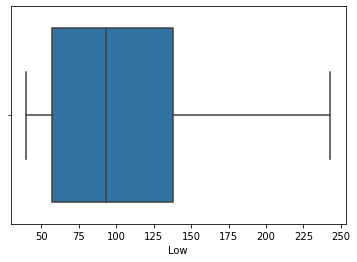

In [364]:
sns.boxplot(x=df['Low'])

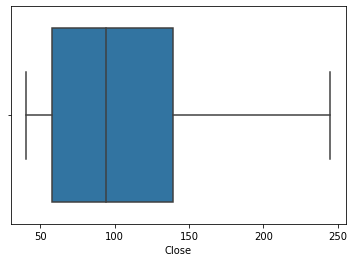

In [365]:
sns.boxplot(x=df['Close'])

## **Menangani Outlier Menggunakan Interquartile**
Dengan menggunakan interquartil, nilai pencilan yang melebihi nilai kuartil1(Q1) akan diubah menjadi nilai Q1. Sementara itu, nilai pencilan yang kurang dari nilai kuartil3(Q3) akan diubah nilainya menjadi nilai Q3. Sehingga, tidak ada lagi nilai pencilan yang tentunya akan meningkatkan efektifitas model.

In [366]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]
 
# Cek ukuran dataset setelah kita drop outliers
df.shape

(1411, 5)

## **Membuat Grafik menggunakan matplotlib**

Setelah kita melakukan data cleaning dengan proses EDA. Kita akan melihat grafik dari data microsoft_stock.csv. Libarary yang digunakan menggunakan matplotlib.pyplot. Sumbu-x adalah index penanggalan dan sumbu-y hanya menggunakan harga close, open, high, dan low. Tetapi, harga keempatnya hampir sama dan terlihat berdekatan hasil grafiknya.



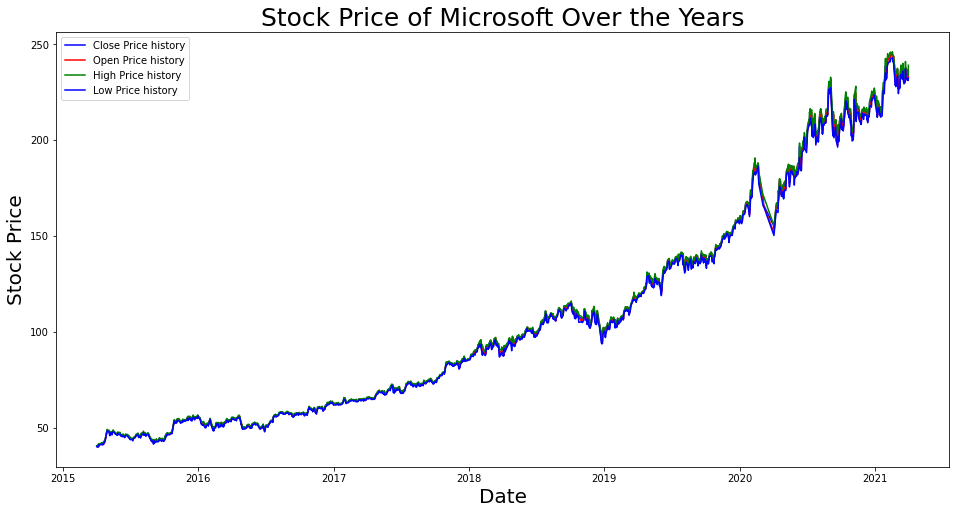

In [367]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='b')
plt.plot(df['Open'], label='Open Price history',color='r')
plt.plot(df['High'], label='High Price history',color='g')
plt.plot(df['Low'], label='Low Price history',color='b')

plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft Over the Years',size=25);
plt.legend()
plt.show()

In [368]:
data = df['Close'].values
dates = df.index.values

# **Membagi Dataset**

Pada proses ini data akan dibagi dengan porsi 80:20 atau 80% data train dan 20% data test dengan random state brnilai False dan shuffle bernilai False

In [369]:
# Membagi data set 80:20
x_train, x_test, y_train, y_test = train_test_split(dates, data, test_size=0.2, random_state=False, shuffle=False)
y_train

array([ 40.72,  40.29,  41.55, ..., 155.53, 154.69, 154.37])

## **Normalize Data menggunakan MinMaxScaler**

selanjutnya, data akan dinormalisasi menggunakan MinMaxScaler yang dimana data train menggunakan fit_transform dan data test menggunakan transform()

In [370]:
from sklearn.preprocessing import StandardScaler
y_train = y_train.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
y_train = scaler.fit_transform(y_train)

y_test = y_test.reshape(-1, 1)
y_test = scaler.transform(y_test)
print(len(y_train))
print(len(y_test))

1128
283


## **Windowing Data**

In [371]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds= ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [372]:
early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

## **Model LSTM**

In [373]:
train_set = windowed_dataset(y_train, window_size=10, batch_size=32, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=10, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(10, 1)),
    tf.keras.layers.RepeatVector(10),
    tf.keras.layers.LSTM(200, activation='relu', return_sequences=True),
    tf.keras.layers.Dense(10)
    ])

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

In [374]:
history = model.fit(train_set, epochs=epochs, batch_size=144, verbose=1,
         validation_data=val_set, callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 5s 60ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - val_loss: 0.4298 - val_mean_squared_error: 0.4298 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 2s 44ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.3095 - val_mean_squared_error: 0.3095 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 2s 43ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.6855 - val_mean_squared_error: 0.6855 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 2s 45ms/step - loss: 6.7379e-04 - mean_squared_error: 6.7379e-04 - val_loss: 0.4219 - val_mean_squared_error: 0.4219 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 2s 45ms/step - loss: 5.4630e-04 - mean_squared_error: 5.4630e-04 - val_loss: 0.3658 - val_mean_squared_error: 0.3658 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 2s 44ms/step - loss: 4.3847e-04 - mean_squared_error: 4.3847e-

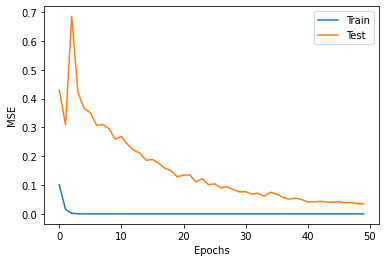

In [375]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);

## **Model Forecasting**

In [376]:
data2 =df.reset_index()

In [377]:
from statsmodels.base.transform import BoxCox
bc=BoxCox()
data2['Close'], lmbda=bc.transform_boxcox(data2['Close'])

In [378]:
new_data=data2[["Date","Close"]]
new_data.columns=["ds","y"]

In [379]:
model_params={
    "daily_seasonality":False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "seasonality_mode": "multiplicative",
    "growth": "logistic"
}

In [380]:
from fbprophet import Prophet
model=Prophet(**model_params)

new_data["cap"]=new_data['y'].max() + new_data['y'].std()*0.05

model.fit(new_data)
future=model.make_future_dataframe(periods=365)
future["cap"]=new_data["cap"].max()
forecast=model.predict(future)

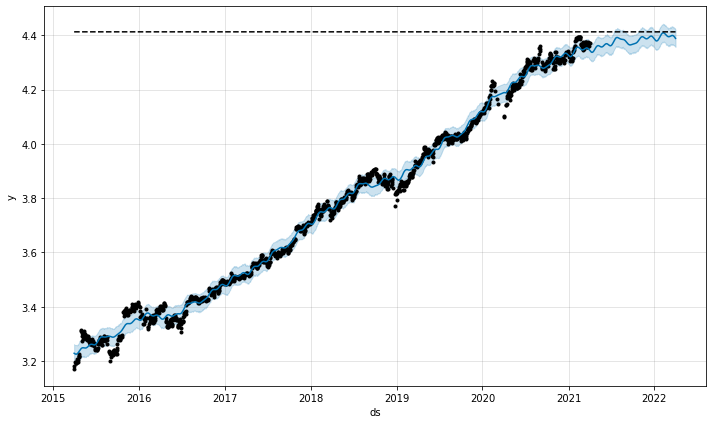

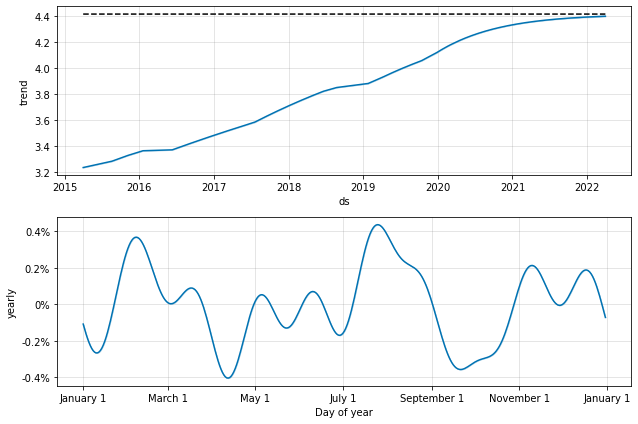

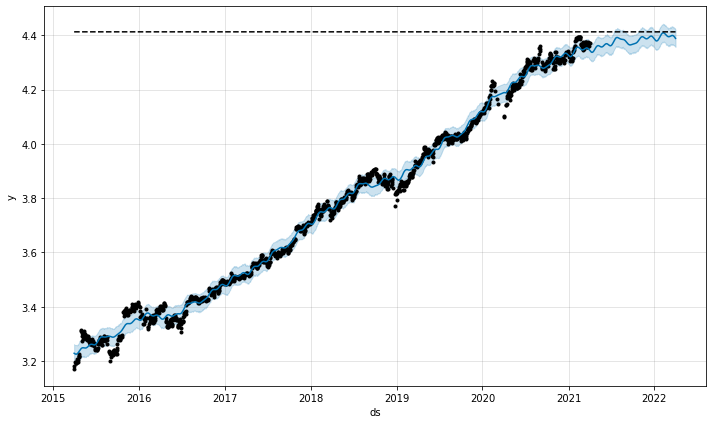

In [381]:
model.plot_components(forecast)
model.plot(forecast)